In [1]:
%matplotlib inline
import numpy as np
from scipy import stats, interpolate
from blimpy import Waterfall
from matplotlib import pyplot as plt
from bisect import bisect_left
from tqdm import tqdm
import dask.array as da
import h5py as h5

from utils import *

fil_path = "data/filterbanks/"
h5_path = "data/h5/"

test_fil = fil_path + "blc20_guppi_57991_48899_3C161_0007.gpuspec.0000.fil"

fri_obs = h5_path + "GBT_57532_09539_HIP56445_fine.h5"

In [4]:
# Show Info
wf = Waterfall(fri_obs, load_data=False)
wf.info()

blimpy.file_wrapper INFO     Skipping loading data ...

--- File Info ---
b'DIMENSION_LABELS' : [b'frequency' b'feed_id' b'time']
     b'az_start' :                              0.0
    b'data_type' :                                1
         b'fch1' :                    1926.26953125
         b'foff' :           -2.835503418452676e-06
   b'machine_id' :                               20
        b'nbits' :                               32
       b'nchans' :                        318230528
         b'nifs' :                                1
  b'source_name' :                      b'HIP56445'
      b'src_dej' :                     3d03m34.006s
      b'src_raj' :                    11h34m21.699s
 b'telescope_id' :                                6
        b'tsamp' :                     17.986224128
       b'tstart' :                57532.11040509259
     b'za_start' :                              0.0

Num ints in file :                               16
      File shape :               (16,

In [ ]:
wf = Waterfall(fri_obs, f_stop=1070)
wf.info()

In [5]:
coarse_channel_width = np.int(np.round(187.5/64/abs(wf.header[b'foff'])))
coarse_channel_width

1033216

In [5]:
freqs, data = wf.grab_data(f_start=0, f_stop=1070)
print(data.shape)
freqs = freqs[::-1]
data = data[:,::-1]

KeyboardInterrupt: 

In [ ]:
data = data[:, :15 * coarse_channel_width]
freqs = freqs[:15 * coarse_channel_width]

integrated = np.sum(data, axis=0)/len(data)
for n in np.nonzero(integrated > 10**13):
    integrated[n] = (integrated[n-1] + integrated[n+1]) /2
plt.figure()
plt.plot(freqs[:15*1033216], np.log(integrated))

In [ ]:
channels = np.reshape(integrated, (-1, coarse_channel_width))

In [ ]:
# plot spectrum and selected channel (logged)

channel_ind = 4
chan_freqs = freqs[coarse_channel_width * channel_ind: coarse_channel_width * (channel_ind+1)]
plt.figure()
plt.plot(freqs[:15*coarse_channel_width], np.log(integrated))


plt.plot(chan_freqs, np.log(channels[channel_ind]))

In [ ]:
plt.figure()
plt.plot(chan_freqs, channels[channel_ind])

Downsampling by a factor of (1, 3531)


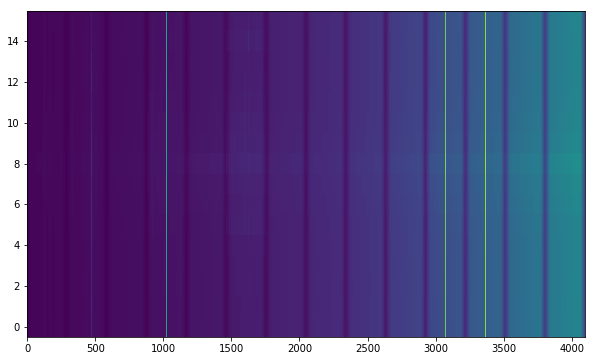

In [9]:
orig_block1 = np.load("original_a/0.npy")
orig_block1 = orig_block1[:,0,:]
plot_segment(orig_block1)

Downsampling by a factor of (1, 3531)
(16, 14465024)


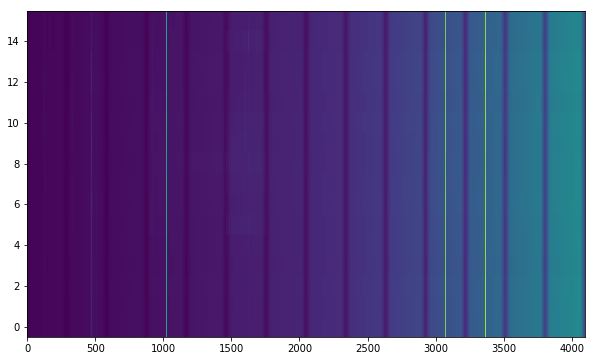

In [11]:
block1 = np.load("normalized_a/0.npy")
block2 = np.load("normalized_a/1.npy")

block1 = block1[:, 0, :]
block2 = block2[:, 0, :]

plot_segment(block1)
print(block1.shape)

In [12]:
integrated = np.mean(block1, axis=0)
for n in np.nonzero(integrated > 800):
    integrated[n] = (integrated[n-1] + integrated[n+1]) /2
channels = np.reshape(integrated, (-1, coarse_channel_width))
channels.shape

(14, 1033216)

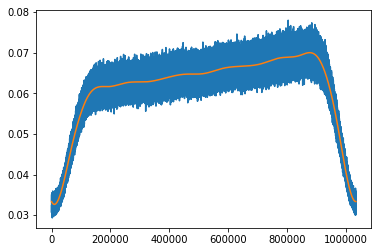

In [30]:
order = 16
channel_ind = 7
x = np.arange(coarse_channel_width)
knots = np.arange(0, coarse_channel_width, coarse_channel_width//order+1)
spl = interpolate.splrep(x, channels[channel_ind], t=knots[1:])
chan_fit = interpolate.splev(x, spl)

plt.figure()
plt.plot(x, channels[channel_ind])
plt.plot(x, chan_fit)

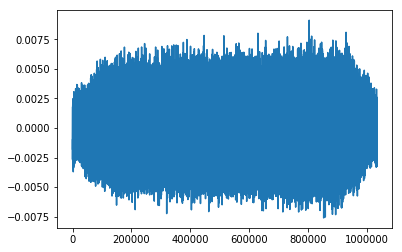

In [31]:
residuals = channels[channel_ind] - chan_fit
plt.figure()
plt.plot(x, residuals)

Downsampling by a factor of (1, 252)


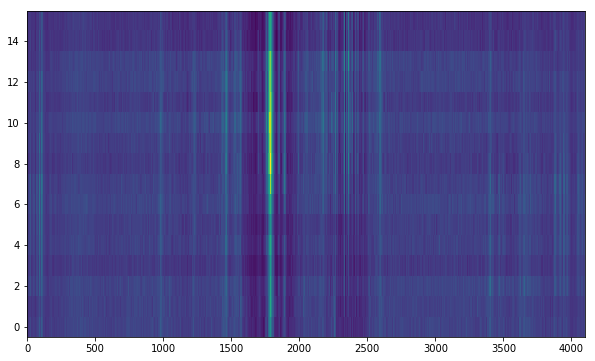

In [91]:
norm_chan0 = block1[:, :coarse_channel_width] - chan_fit

norm_chan0[norm_chan0 > 800] = 0
    
plot_segment(norm_chan0)

In [81]:
def fit_channel_bandpass(channel, integrated_channel, channel_width=1033216, spl_order=16):
    x = np.arange(channel_width)
    knots = np.arange(0, channel_width, channel_width//spl_order+1)
    spl = interpolate.splrep(x, integrated_channel, t=knots[1:])
    chan_fit = interpolate.splev(x, spl)
    return chan_fit

def remove_channel_bandpass(channel, integrated_channel, channel_width=1033216, spl_order=16):
    fit = fit_channel_bandpass(channel, integrated_channel, channel_width, spl_order)
    return channel - fit

In [77]:
fit_1 = fit_channel_bandpass(block1[:, :coarse_channel_width], channels[0])

In [82]:
np.allclose(norm_chan0, block1[:, :coarse_channel_width]-chan_fit)

True

In [83]:
np.allclose(norm_chan0, remove_channel_bandpass(block1[:, :coarse_channel_width], channels[0]))

True

In [97]:
remove_channel_bandpass(block1[:, coarse_channel_width*(channel_ind):coarse_channel_width*(channel_ind+1)],
                       channels[channel_ind])

array([[-2.60792011e-03,  1.08881888e-03, -9.18213611e-04, ...,
         1.98596095e-04,  7.59465187e-04, -6.26521991e-04],
       [-2.05675968e-03, -9.21343104e-04,  1.07615501e-03, ...,
         7.97706594e-04,  1.64060717e-03,  4.12821895e-04],
       [-1.09953709e-04, -9.59888683e-04,  1.66825358e-03, ...,
         3.00564741e-04,  3.81667666e-04, -1.12907297e-03],
       ...,
       [-2.06767484e-04, -1.34819245e-03, -2.98925802e-03, ...,
        -6.47177050e-04,  1.27304116e-03,  5.01327342e-04],
       [ 1.50114214e-03,  2.55409395e-05,  2.00460332e-04, ...,
        -9.17847330e-04, -6.46898956e-04, -8.83801715e-04],
       [-2.41719363e-03, -2.40000722e-03, -1.34879291e-03, ...,
         3.36576191e-04,  5.30392430e-04, -2.54063548e-05]])

In [111]:
def clean(channel_ind):
        return remove_channel_bandpass(block1[:, coarse_channel_width*(channel_ind):coarse_channel_width*(channel_ind+1)],
                       channels[channel_ind], coarse_channel_width)

def normalize_block():
    from multiprocessing import Pool
    with Pool(12) as p:
        cleaned = p.map(clean, range(14))
    return cleaned

In [113]:
normalized = normalize_block()

In [119]:
np.concatenate(normalized, axis=1).shape == block1.shape

True

In [120]:
blocks = [block1]

In [121]:
for block in blocks:
    def clean(channel_ind):
        return remove_channel_bandpass(block1[:, coarse_channel_width*(channel_ind):coarse_channel_width*(channel_ind+1)],
                       channels[channel_ind], coarse_channel_width)

    def normalize_block():
        from multiprocessing import Pool
        with Pool(12) as p:
            cleaned = p.map(clean, range(14))
        return cleaned
    normalized = normalize_block()
    normalized = np.concatenate(normalized, axis=1)

Downsampling by a factor of (1, 3531)


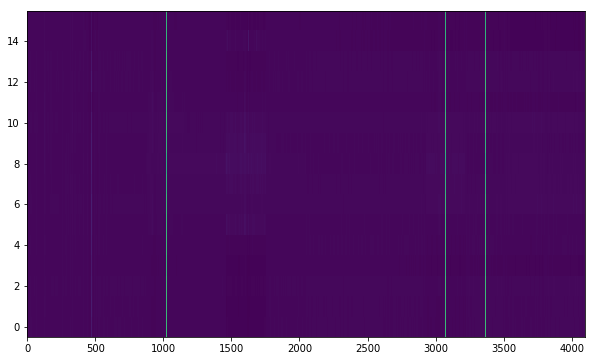

In [124]:
plot_segment(normalized)